In [ ]:
import pandas as pd
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
city_weather = pd.read_pickle("/content/drive/MyDrive/city_weather.pkl")

In [ ]:
city_weather.head()

,name,date_txt,clouds,rain,wind_direction_deg,wind_speed,temp_min,humidity,pressure,above_sea_level
0,Mumbai,2019-10-16 12:00:00,16,0.0,12.291,2.461,304.233,63,1010,4.203
1,Mumbai,2019-10-16 15:00:00,0,0.0,58.298,1.823,302.000,65,1011,3.713
2,Mumbai,2019-10-16 18:00:00,12,0.0,88.312,2.105,300.400,66,1011,3.158
3,Mumbai,2019-10-16 21:00:00,100,0.0,69.014,2.295,299.885,64,1010,3.224
4,Mumbai,2019-10-17 00:00:00,100,0.0,54.559,2.768,298.995,66,1010,3.178


In [ ]:
# Now for our model purpose we do not need name and date_txt column 
city_weather.drop(['name','date_txt'],inplace=True,axis=1)

In [ ]:
X = city_weather.drop('temp_min', axis=1)
y = city_weather['temp_min']

# Linear Regression Model with Lasso,Ridge and Elastic Net

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
from sklearn import metrics
from sklearn.model_selection import cross_val_score

def cross_val(model):
    pred = cross_val_score(model, X, y, cv=10)
    return pred.mean()

def print_evaluate(true, predicted):  
    mae = metrics.mean_absolute_error(true, predicted)
    mse = metrics.mean_squared_error(true, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    r2_square = metrics.r2_score(true, predicted)
    print('MAE:', mae)
    print('MSE:', mse)
    print('RMSE:', rmse)
    print('R2 Square', r2_square)
    print('__________________________________')
    
def evaluate(true, predicted):
    mae = metrics.mean_absolute_error(true, predicted)
    mse = metrics.mean_squared_error(true, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    r2_square = metrics.r2_score(true, predicted)
    return mae, mse, rmse, r2_square

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('std_scalar', StandardScaler())
])

X_train = pipeline.fit_transform(X_train)
X_test = pipeline.transform(X_test)

In [ ]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression(normalize=True)
lin_reg.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

In [ ]:
print(lin_reg.intercept_)

299.3338942857143


In [ ]:
# From here we can understand that highly predictive feature for min_temp is humidity, above_sea_level and finally pressure, they all predict negatively
coeff_df = pd.DataFrame(lin_reg.coef_, X.columns, columns=['Coefficient'])
coeff_df

,Coefficient
clouds,0.635896
rain,0.270520
wind_direction_deg,0.046397
wind_speed,0.531681
humidity,-2.402255
pressure,-0.924285
above_sea_level,-1.821145


In [ ]:
pred = lin_reg.predict(X_test)

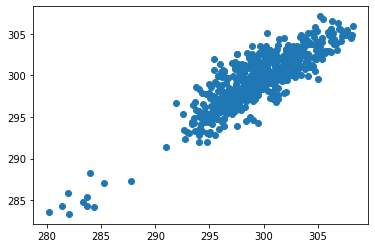

In [ ]:
plt.scatter(y_test, pred)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


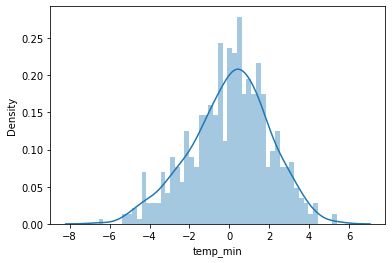

In [ ]:
import seaborn as sns
sns.distplot((y_test - pred), bins=50)

In [ ]:
test_pred = lin_reg.predict(X_test)
train_pred = lin_reg.predict(X_train)

print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, test_pred)
print('Train set evaluation:\n_____________________________________')
print_evaluate(y_train, train_pred)

Test set evaluation:
_____________________________________
MAE: 1.569250909885891
MSE: 3.9031939456426623
RMSE: 1.9756502589382217
R2 Square 0.7601582757611358
__________________________________
Train set evaluation:
_____________________________________
MAE: 1.60426995175209
MSE: 4.053268757155298
RMSE: 2.0132731451929957
R2 Square 0.7410790066020303
__________________________________


In [ ]:
results_df = pd.DataFrame(data=[["Linear Regression", *evaluate(y_test, test_pred) , cross_val(LinearRegression())]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square', "Cross Validation"])
results_df

,Model,MAE,MSE,RMSE,R2 Square,Cross Validation
0,Linear Regression,1.569251,3.903194,1.97565,0.760158,0.636281


In [ ]:
from sklearn.linear_model import Ridge

model = Ridge(alpha=100, solver='cholesky', tol=0.0001, random_state=42)
model.fit(X_train, y_train)
pred = model.predict(X_test)

test_pred = model.predict(X_test)
train_pred = model.predict(X_train)

print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, test_pred)
print('====================================')
print('Train set evaluation:\n_____________________________________')
print_evaluate(y_train, train_pred)

Test set evaluation:
_____________________________________
MAE: 1.5831180386140435
MSE: 3.9584134687047534
RMSE: 1.9895762032917346
R2 Square 0.7567651710865283
__________________________________
Train set evaluation:
_____________________________________
MAE: 1.6166066593232702
MSE: 4.114136719999067
RMSE: 2.0283334834289617
R2 Square 0.7371907883885704
__________________________________


In [ ]:
results_df_2 = pd.DataFrame(data=[["Ridge Regression", *evaluate(y_test, test_pred) , cross_val(Ridge())]], 
                            columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square', "Cross Validation"])
results_df = results_df.append(results_df_2, ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square,Cross Validation
0,Linear Regression,1.569251,3.903194,1.975650,0.760158,0.636281
1,Ridge Regression,1.583118,3.958413,1.989576,0.756765,0.636282


In [ ]:
from sklearn.linear_model import Lasso

model = Lasso(alpha=0.1, 
              precompute=True, 
#               warm_start=True, 
              positive=True, 
              selection='random',
              random_state=42)
model.fit(X_train, y_train)

test_pred = model.predict(X_test)
train_pred = model.predict(X_train)

print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, test_pred)
print('====================================')
print('Train set evaluation:\n_____________________________________')
print_evaluate(y_train, train_pred)

Test set evaluation:
_____________________________________
MAE: 2.918511854833635
MSE: 14.957705515052039
RMSE: 3.8675192973082937
R2 Square 0.08088556926766566
__________________________________
Train set evaluation:
_____________________________________
MAE: 2.8755765933039337
MSE: 14.26037117883084
RMSE: 3.7762906639758067
R2 Square 0.08905387402980236
__________________________________


In [ ]:
results_df_2 = pd.DataFrame(data=[["Lasso Regression", *evaluate(y_test, test_pred) , cross_val(Lasso())]], 
                            columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square', "Cross Validation"])
results_df = results_df.append(results_df_2, ignore_index=True)
results_df
# Lasso may reduce the value of coefficient to zero for a parameter and hence lasso suffers with oversimplification

,Model,MAE,MSE,RMSE,R2 Square,Cross Validation
0,Linear Regression,1.569251,3.903194,1.975650,0.760158,0.636281
1,Ridge Regression,1.583118,3.958413,1.989576,0.756765,0.636282
2,Lasso Regression,2.918512,14.957706,3.867519,0.080886,0.580044


In [ ]:
from sklearn.linear_model import ElasticNet

model = ElasticNet(alpha=0.1, l1_ratio=0.9, selection='random', random_state=42)
model.fit(X_train, y_train)

test_pred = model.predict(X_test)
train_pred = model.predict(X_train)

print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, test_pred)
print('====================================')
print('Train set evaluation:\n_____________________________________')
print_evaluate(y_train, train_pred)

Test set evaluation:
_____________________________________
MAE: 1.5821597313469413
MSE: 3.9582623449173266
RMSE: 1.9895382240402737
R2 Square 0.7567744572737521
__________________________________
Train set evaluation:
_____________________________________
MAE: 1.6244649227538541
MSE: 4.130625447911759
RMSE: 2.032394018863409
R2 Square 0.7361374958321648
__________________________________


In [ ]:
results_df_2 = pd.DataFrame(data=[["Elastic Net Regression", *evaluate(y_test, test_pred) , cross_val(ElasticNet())]], 
                            columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square', "Cross Validation"])
results_df = results_df.append(results_df_2, ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square,Cross Validation
0,Linear Regression,1.569251,3.903194,1.975650,0.760158,0.636281
1,Ridge Regression,1.583118,3.958413,1.989576,0.756765,0.636282
2,Lasso Regression,2.918512,14.957706,3.867519,0.080886,0.580044
3,Elastic Net Regression,1.582160,3.958262,1.989538,0.756774,0.603843


# Random Forest Regressor

In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf_reg = RandomForestRegressor(n_estimators=1000)
rf_reg.fit(X_train, y_train)

test_pred = rf_reg.predict(X_test)
train_pred = rf_reg.predict(X_train)

print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, test_pred)

print('Train set evaluation:\n_____________________________________')
print_evaluate(y_train, train_pred)

Test set evaluation:
_____________________________________
MAE: 0.892672567546776
MSE: 1.6206027096934603
RMSE: 1.273028950846547
R2 Square 0.9004179260338914
__________________________________
Train set evaluation:
_____________________________________
MAE: 0.34324328161087203
MSE: 0.24401900898395312
RMSE: 0.4939828023159846
R2 Square 0.9844121749630893
__________________________________


In [ ]:
results_df_2 = pd.DataFrame(data=[["Random Forest Regressor", *evaluate(y_test, test_pred), 0]], 
                            columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square', 'Cross Validation'])
results_df = results_df.append(results_df_2, ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square,Cross Validation
0,Linear Regression,1.569251,3.903194,1.975650,0.760158,0.636281
1,Ridge Regression,1.583118,3.958413,1.989576,0.756765,0.636282
2,Lasso Regression,2.918512,14.957706,3.867519,0.080886,0.580044
3,Elastic Net Regression,1.582160,3.958262,1.989538,0.756774,0.603843
4,Random Forest Regressor,0.892673,1.620603,1.273029,0.900418,0.000000


<BarContainer object of 7 artists>

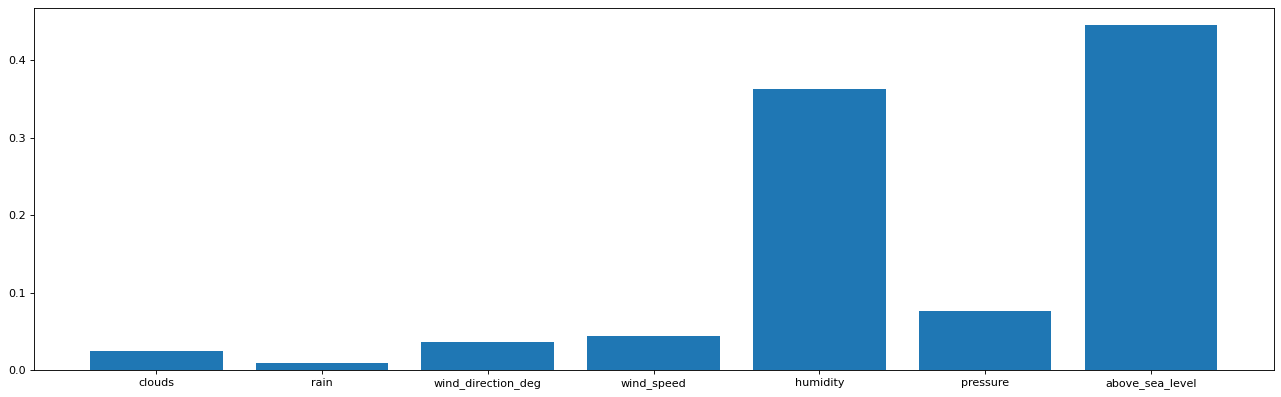

In [ ]:
# Again Random forest fives the same result as humidity and sea_level being the most predictive features 
from matplotlib.pyplot import figure
figure(figsize=(20, 6), dpi=80)
plt.bar(X.columns,rf_reg.feature_importances_)